In [1]:
import sklearn
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='ticks', palette='Set2')
import pandas as pd
import numpy as np
import math
from __future__ import division


/home/casey/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


### Supervised learning example: Iris data

* evaluate with Naive Bayes
* evaluate with sklearn logistic regression
* evaluate with custom logistic regression

### What is involved?

* statistics
* convex optimization (gradient descent)
* linear algebra
* calculus (first derivative)


In [3]:
#
#    load the iris data
#
# The iris dataset contains 4 attributes for 3 types of iris plants. 
# The purpose is to classify which plant you have just based on the attributes. 
# To simplify things, we will only consider 2 attributes and 2 classes. Here are the data visually:
#

data = datasets.load_iris()
X = data.data[:150, :3]
y = data.target[:150]
X_full = data.data[:150, :]
print(y[10:20])
X[10:20]

[0 0 0 0 0 0 0 0 0 0]


array([[5.4, 3.7, 1.5],
       [4.8, 3.4, 1.6],
       [4.8, 3. , 1.4],
       [4.3, 3. , 1.1],
       [5.8, 4. , 1.2],
       [5.7, 4.4, 1.5],
       [5.4, 3.9, 1.3],
       [5.1, 3.5, 1.4],
       [5.7, 3.8, 1.7],
       [5.1, 3.8, 1.5]])

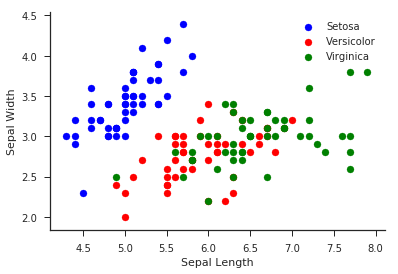

In [4]:
#
#  plot the iris sepal width and sepal lengths
#
from matplotlib.backends.backend_pdf import PdfPages

setosa = plt.scatter(X[:50,0], X[:50,1], c='b')
versicolor = plt.scatter(X[50:100,0], X[50:100,1], c='r')
virginica = plt.scatter(X[100:150,0], X[100:150,1], c='g')
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.legend((setosa, versicolor, virginica), ("Setosa", "Versicolor", "Virginica"))
sns.despine()

plt.savefig('plot.pdf', bbox_inches='tight')

In [5]:
#
#   train and evaluate a Naive Bayes Classifier
# 

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(data.data, data.target).predict(data.data)
100 * (1.0 - ((data.target != y_pred).sum()/data.data.shape[0]))

96.0

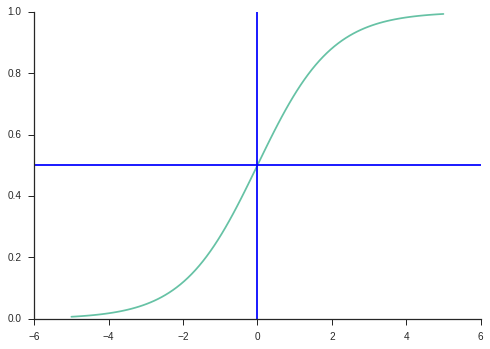

In [12]:
x_values = np.linspace(-5, 5, 100)
y_values = [1 / (1 + math.e**(-x)) for x in x_values]
plt.plot(x_values, y_values)
plt.axhline(.5)
plt.axvline(0)
sns.despine()

#
# binary 1/0 decision
# similar to linear regression, only we want to fit a curve to it to result in a probability between 0 and 1
#

In [13]:
def logistic_func(theta, x):
    '''
    The well-known logit function
    '''
    return float(1) / (1 + math.e**(-x.dot(theta)))

In [14]:
def log_gradient(theta, x, y):
    '''
    computes the log of the gradient
    '''
    first_calc = logistic_func(theta, x) - np.squeeze(y)
    final_calc = first_calc.T.dot(x)
    return final_calc

In [15]:
def cost_func(theta, x, y):
    '''
    computes the cost function; i.e., (for linear regression) minimize the distance between a regression line
    and all of the points
    '''
    log_func_v = logistic_func(theta,x)
    y = np.squeeze(y)
    step1 = y * np.log(log_func_v)
    step2 = (1-y) * np.log(1 - log_func_v)
    final = -step1 - step2
    return np.mean(final)

In [16]:
def grad_desc(theta_values, X, y, lr=.001, converge_change=.001):
    '''
    the hard part of learning: gradient descent. Fortunately, the logistic function is convex --
    the derivitive is itself
    '''
    #normalize
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    #setup cost iter
    cost_iter = []
    cost = cost_func(theta_values, X, y)
    cost_iter.append([0, cost])
    change_cost = 1
    i = 1
    while(change_cost > converge_change):
        old_cost = cost
        theta_values = theta_values - (lr * log_gradient(theta_values, X, y))
        cost = cost_func(theta_values, X, y)
        cost_iter.append([i, cost])
        change_cost = old_cost - cost
        i+=1
    return theta_values, np.array(cost_iter)

In [17]:
def pred_values(theta, X, hard=True):
    '''
    predictor values
    '''
    #normalize
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    pred_prob = logistic_func(theta, X)
    pred_value = np.where(pred_prob >= .5, 1, 0) # note the threshold of 0.5
    if hard:
        return pred_value
    return pred_prob

In [18]:
shape = X.shape[1]
y_flip = np.logical_not(y) #flip Setosa to be 1 and Versicolor to zero to be consistent
betas = np.zeros(shape)
fitted_values, cost_iter = grad_desc(betas, X, y_flip)
fitted_values

array([-0.90883038,  1.10153041, -1.49518982])

In [19]:
predicted_y = pred_values(fitted_values, X)
np.sum(y_flip == predicted_y)

147

#### (beware of the cardinal sin of machine learning!)

In [20]:
#
# how does sklearn perform?
#

from sklearn import linear_model
logreg = linear_model.LogisticRegression()
logreg.fit(X, y_flip)
sum(y_flip == logreg.predict(X))

150